In [14]:
import numpy as np
import os
import re

import CDEF

import scipy.optimize
from scipy.optimize import root, Bounds

import time

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, NullFormatter

from build123d import export_stl
from ocp_vscode import show


def bipyramid(fillet_radius, R, h, base_corners=5, center=(0,0,0), rotation=0.0):
    from build123d import Solid, Shell, Face, Wire, export_stl, fillet
    from scipy.spatial import ConvexHull
    import numpy as np

    def bipyramid_vertices(R, h, base_corners=5, center=(0,0,0), rotation=0.0):
        """Generate vertices of a bipyramid with a variable amount of base corners.

        Args:
            R (float): radius of the base.
            h (float): height of the apices above and below the base plane.
            center (tuple): (x, y, z) coordinates of the bipyramid center.
            rotation (float): rotation angle in radians applied to the base pentagon.

        Returns:
            List of 7 tuples [(x,y,z), ...] representing the bipyramid vertices.
        """
        cx, cy, cz = center
        vertices = []
        
        # 5 vertices of pentagonal base in XY plane with rotation
        for i in range(base_corners):
            angle = 2 * np.pi * i / base_corners + rotation
            x = cx + R * np.cos(angle)
            y = cy + R * np.sin(angle)
            z = cz
            vertices.append((x, y, z))
        
        # apex vertex at +h and -h
        vertices.append((cx, cy, cz + h))
        vertices.append((cx, cy, cz - h))
        
        return vertices

    vertices = bipyramid_vertices(R=R, h=h, base_corners=base_corners, center=center, rotation=rotation)

    # Create a convex hull from the vertices
    hull = ConvexHull(vertices).simplices.tolist()

    # Create faces from the vertex indices
    faces = []
    for face_vertex_indices in hull:
        corner_vertices = [vertices[i] for i in face_vertex_indices]
        faces.append(Face(Wire.make_polygon(corner_vertices)))

    # Create the solid from the Faces
    bipy = Solid(Shell(faces)).clean()
    if fillet_radius > 0:
        bipy = fillet(bipy.edges(), radius=fillet_radius)
    return bipy


def bipyramid2(fillet_radius, R, h, base_corners=5):
    from build123d import BuildPart, Circle, RegularPolygon, BuildSketch, offset, loft, Plane, chamfer, mirror, fillet, Axis
    
    with BuildPart() as bipy:
        with BuildSketch(Plane.XY.offset(h)) as bipy_top:
            Circle(R*1e-3)
        with BuildSketch() as bipy_base:
            RegularPolygon(radius=R, side_count=base_corners)
            offset(amount=fillet_radius)
        loft()
        with BuildSketch(Plane.XY.offset(-h)) as bipy_bot:
            Circle(R*1e-3)
        mirror(about=Plane.XY)

    return bipy
    

def build123d_to_mesh(shape, tolerance=1e-3):
    all_tris = []
    for f in shape.faces():
        tess = f.tessellate(tolerance)
        # Case 1: tess returns (vertices, triangles)
        if isinstance(tess, tuple) and len(tess) == 2:
            vertices, triangles = tess
            # Convert each vertex to (x,y,z)
            coords = [ (v.X, v.Y, v.Z) if hasattr(v, "X") else tuple(v) for v in vertices ]
            for tri in triangles:
                all_tris.append([ coords[i] for i in tri ])
        # Case 2: tess returns list of triangles directly
        else:
            for tri in tess:
                # Convert each Vector to tuple if needed
                all_tris.append([ (v.X, v.Y, v.Z) if hasattr(v, "X") else tuple(v) for v in tri ])
    return np.array(all_tris, dtype=np.float64)


# Function to make 3D axes equal
def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale so that spheres appear as spheres."""
    limits = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
    centers = np.mean(limits, axis=1)
    max_range = 0.5 * np.max(limits[:,1] - limits[:,0])
    for center, setter in zip(centers, [ax.set_xlim3d, ax.set_ylim3d, ax.set_zlim3d]):
        setter(center - max_range, center + max_range)


def next_folder(prefix, base_dir="."):
    """
    Find the next folder with prefix_xxxx in base_dir.
    If none exists, create prefix_0000.
    Otherwise, create prefix_<max+1> with leading zeros.
    """
    # Regex to match prefix_XXXX where XXXX are digits
    pattern = re.compile(rf"^{prefix}_(\d{{4}})$")
    
    max_num = -1
    for name in os.listdir(base_dir):
        match = pattern.match(name)
        if match:
            num = int(match.group(1))
            max_num = max(max_num, num)
    
    # Determine next number
    next_num = max_num + 1 if max_num >= 0 else 0
    folder_name = f"{prefix}_{next_num:04d}"
    folder_path = os.path.join(base_dir, folder_name)
    
    os.makedirs(folder_path, exist_ok=False)  # fail if it already exists
    return folder_path


def plot_fitresults(data, fit_values, unitmodel_args, distribution, N):
    
    if len(fit_values) > 5:
        unitscattering = bipy_curve(fit_values[5], **unitmodel_args)
    else:
        unitscattering = bipy_curve(**unitmodel_args)

    #q-range of fit
    qvec = np.logspace(-3,0,1000)

    fit = CDEF.scattering_model(unitscattering, qvec, *fit_values[:4], distribution)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex='col', sharey='row', gridspec_kw={'height_ratios':[3,1]})

    r = fit_values[1]
    r_bipy = 2*r / (1 + np.cos(np.pi/5))
    e_bipy = 2*r_bipy * np.sin(np.pi/5)

    ax[0].set_title(f'bipyramid mean side length = {e_bipy:.1f} nm, {N} pts')
    ax[0].set_xscale('log')
    ax[0].set_ylabel(r'$I$ / a. u.', fontsize=12)
    ax[0].set_yscale('log')

    #Frame limits
    ax[0].set_ylim([1e-1, 1e5])
    ax[0].set_xlim([3e-2, 1e0])

    ax[0].errorbar(data[:,0], data[:,1], 
                yerr = data[:,2], fmt='.', ecolor='k', 
                capsize= 2, capthick=1, alpha=0.6, markersize = 5, label = 'Experimental data', zorder=1)
    ax[0].loglog(fit[:,0], fit[:,1], label='Fit')

    ax[0].legend()

    #########################################
    ax[1].set_xlabel(r'$q$ / nm$^{-1}$', fontsize=12)
    ax[1].set_ylabel(r'$I$ / $I_{\mathrm{Fit}}$', fontsize=12)

    #Frame limits
    ax[1].set_ylim([0.85, 1.15])

    ax[1].errorbar(data[:, 0], data[:, 1]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
                yerr = data[:, 2]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
                fmt='.', ecolor='k', capsize= 2, capthick=1, alpha=0.6, markersize = 5, 
                label = 'Experimental data', zorder=1)

    ax[1].plot(fit[:,0], fit[:,1]/fit[:,1], label='Fit')

    # fig.savefig(os.path.join("plots", f"pentagonal_bipyramid.png"))


def bipy_curve(fillet_radius, radius, height, base_corners=5, N=30000):
    # radius = max(radius, 1e-8)
    # height = max(height, 1e-8)
    base_corners = int(base_corners)
    bipy = bipyramid2(fillet_radius=fillet_radius, R=radius, h=height, base_corners=base_corners)
    mesh = build123d_to_mesh(bipy)
    cloud = CDEF.stl_cloud(mesh, N, sequence='halton')
    curve = CDEF.scattering_mono(cloud, selfcorrelation=True)
    return curve

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def plot_paths(path):
    path = np.array(path)
    n_params = path.shape[1]
    plt.figure(figsize=(10, 6))

    for i in range(n_params):
        plt.plot(path[:, i], label=f"param {i}")

    plt.xlabel("Iteration")
    plt.ylabel("Parameter value")
    plt.title("Optimization path of all parameters")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


562


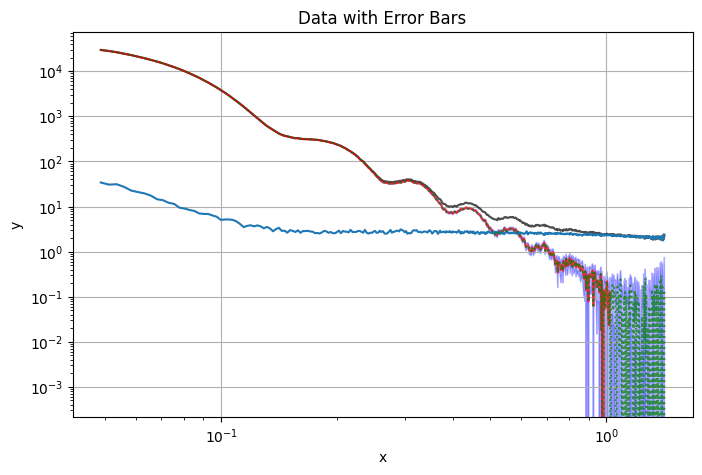

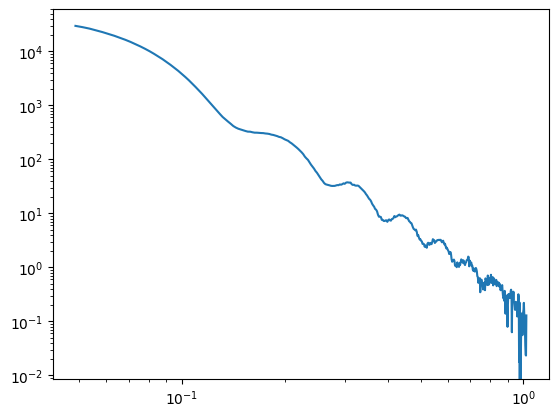

In [ ]:
# Read measured data 

data = np.loadtxt("/messung/kmc/daten/2025/25_kw32/saxs_25_kw32/close_position/hdf_fcm_2025kw32_00097_Sample-Y_-8.0_Sample-X_44.7.dat")
background = np.loadtxt("/messung/kmc/daten/2025/25_kw32/saxs_25_kw32/close_position/hdf_fcm_2025kw32_00097_Sample-Y_-8.0_Sample-X_54.5.dat")
# data = np.loadtxt("/messung/kmc/daten/2025/25_kw32/saxs_25_kw32/hdf_fcm_2025kw32_00097_Sample-Y_-8.0_Sample-X_39.8.dat")

x0 = 0
x_end = 400
print(len(data))
x = data[:,0]
y = data[:,1] - background[:,1]
yerr = data[:,3] + background[:,3]

plt.figure(figsize=(8,5))
# plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=3, ecolor='red', markerfacecolor='blue', markersize=4)
# plt.plot(x, y, 'b-', label='y', alpha=0.3)
plt.fill_between(x, y - yerr, y + yerr, color='blue', alpha=0.3, label='uncertainty')
plt.plot(data[:,0], data[:,1], 'k-', label='y', alpha=0.7)
plt.plot(x[x0:x_end], y[x0:x_end], 'r-', label='y', alpha=0.7)
plt.plot(background[:,0], background[:,1])
plt.plot(x, y, 'g:', label='y', alpha=0.7)
plt.xlabel("x")
plt.ylabel("y")
plt.yscale("log")
plt.xscale("log")
plt.title("Data with Error Bars")
plt.grid(True)
plt.show()

data[:,1] -= background[:,1]
data[:,2] += background[:,2]
data[:,3] += background[:,3]
data = data[x0:x_end,:]

fig, ax = plt.subplots()
ax.loglog(data[:,0], data[:,1])

# create, show and export ideal pentagonal bipyramid

base_corners = 5
side_length = 1
height = side_length * 0.1 * np.sqrt(50-10*np.sqrt(5))
radius = side_length / (2*np.sin(np.pi/base_corners))
fillet_radius = radius * 0.0
port = 3940

bipy = bipyramid(fillet_radius=fillet_radius, R=radius, h=height, base_corners=base_corners)

# show(bipy, port=port)

# export_stl(bipy, "stl/bipy.stl")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
unitscattering calculation time = 2.2308216094970703 s
Optimization terminated successfully.
         Current function value: 21.216899
         Iterations: 5
         Function evaluations: 214
Calculation time = 9.649305582046509 s
fit results = [ 6.20735764e-08  4.69624421e+01  8.43945788e-01 -2.30303415e+00]
chi_squared = 21.216898639344677
mean radius = 51.9 nm
mean side length = 61.0 nm


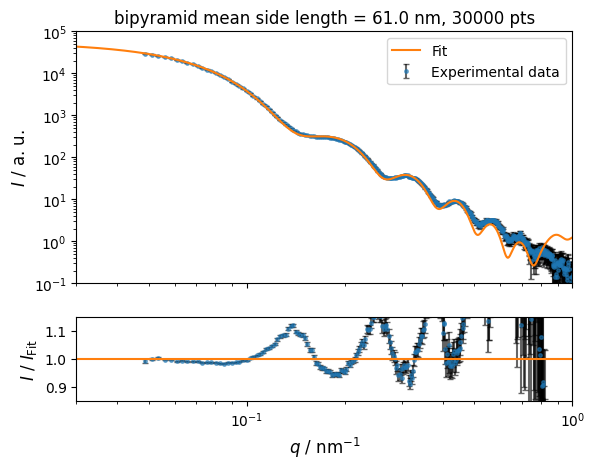

In [17]:
%load_ext autoreload
%autoreload 2

import CDEF

N = 30000

distribution = 'lognormal'
N_C, mean, sigma, c0 =  3e-7, 50, 1, 0
inital_guess = N_C, mean, sigma, c0

unitmodel_args = {'N': N,
                  'base_corners': base_corners,
                  'radius': radius,
                  'height': height,
                  'fillet_radius': fillet_radius}

tic = time.time()
unitscattering = bipy_curve(**unitmodel_args)
print('unitscattering calculation time = {} s'.format(time.time()-tic))
fit_result = scipy.optimize.minimize(CDEF.chi_squared, (inital_guess), args=(data, unitscattering, distribution), 
                                     method = 'Powell', options={'disp' : True})
toc = time.time()
print('Calculation time = {} s'.format(toc-tic))
print(f'fit results = {fit_result.x}')
print(f'chi_squared = {CDEF.chi_squared(fit_result.x, data, unitscattering, distribution)}')


r_mean = fit_result.x[1]
r_bipy = 2*r_mean / (1 + np.cos(np.pi/5))
e_bipy = 2*r_bipy * np.sin(np.pi/5)
print(f"mean radius = {r_bipy:.1f} nm")
print(f"mean side length = {e_bipy:.1f} nm")


plot_fitresults(data, fit_result.x, unitmodel_args, distribution, N)

differential_evolution step 1: f(x)= 1680.9098782246845
differential_evolution step 2: f(x)= 1457.3130289847106
differential_evolution step 3: f(x)= 1457.3130289847106
Polishing solution with 'L-BFGS-B'
Calculation time = 521.8 s
Best fit parameters: [ 5.47165573e-07  4.40983032e+01  2.63069991e+00  1.73568000e-02
 -3.97582827e-01  1.68393261e-01]
Objective value: 1457.3130289847106


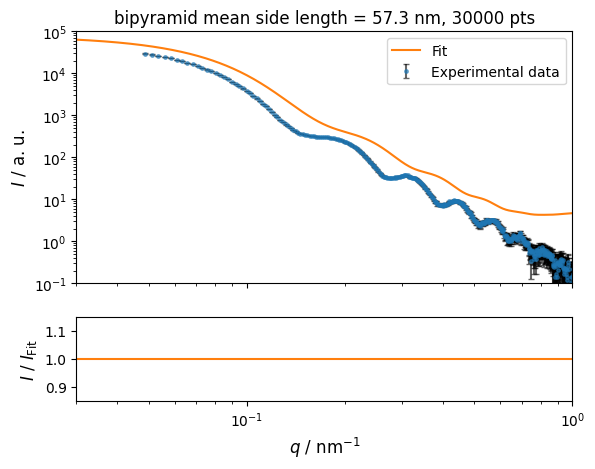

In [19]:
from scipy.optimize import differential_evolution
import numpy as np
import time
import os
os.nice(10)

bounds = [
    (1e-9, 1e-5),      # N_C: physically positive
    (40, 60),         # R0: nm range
    (0.1, 5),          # sigma: width
    (-3.0, 3.0),       # c0: background can be slightly negative
    (-10, 0),          # log_f
    (1e-3, 0.3)        # fillet_radius
]
scales = np.array([1e-7, 10, 1, 1, 1, 0.1])  # typical scale per parameter
bounds_scaled = [
    (lo / scale if lo is not None else None,
     hi / scale if hi is not None else None)
    for (lo, hi), scale in zip(bounds, scales)
]
unitmodel_args = {'N': N,
                  'base_corners': base_corners,
                  'radius': radius,
                  'height': height}

def scaled_objective(x_scaled, *args):
    try:
        x = x_scaled * scales
        return CDEF.neg_log_likelihood_model(x, *args)
    except Exception as e:
        # Return a large penalty for failed geometry or math errors
        return 1e12


tic = time.time()
result = differential_evolution(
    scaled_objective,
    bounds=bounds_scaled,
    args=(data, bipy_curve, unitmodel_args, distribution),
    strategy='best1bin',        # default, works well
    maxiter=3,               # number of generations
    popsize=3,                 # population size multiplier
    tol=1e-6,                   # convergence tolerance
    mutation=(0.5, 1),          # mutation factor range
    recombination=0.7,          # recombination rate
    polish=True,                # local refinement at the end
    disp=True
)

best_fit = result.x * scales
toc = time.time()

print('Calculation time = {:.1f} s'.format(toc - tic))
print('Best fit parameters:', best_fit)
print('Objective value:', result.fun)

plot_fitresults(data, best_fit, unitmodel_args, distribution, N)

In [ ]:
import pickle
from datetime import datetime

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
fn = f"DE_result_{timestamp}.pkl"

res = {"result": result,
       "best_fit": best_fit,
       "unitmodel_args": unitmodel_args,
       "distribution": distribution,
       "N": distribution,
       "bounds": bounds,
       "scales": scales,
       "data": data
       }

# Save to a file
with open(fn, "wb") as f:
    pickle.dump(res, f)

# fn = f"DE_best_fit_{timestamp}.csv"
# np.savetxt(fn, best_fit)

best_fit = [ 5.47165573e-07  4.40983032e+01  2.63069991e+00  1.73568000e-02
 -3.97582827e-01  1.68393261e-01]


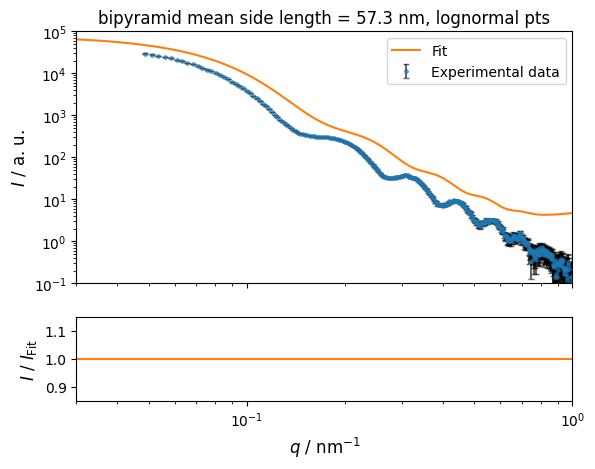

In [33]:
fn = "DE/DE_result_2025-10-10_17-52.pkl"
with open(fn, "rb") as f:
    res = pickle.load(f)

print(f"best_fit = {res["best_fit"]}")
plot_fitresults(res["data"], res["best_fit"], res["unitmodel_args"], res["distribution"], res["N"])